In [ ]:
"""
@author: hosseind
""" 

## Prediction of RUL (Supervised -- Deep Learning)
### Importing necessary libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, max_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.set_option("display.max_rows", None)
import scipy.signal
import scipy.stats
from scipy.optimize import curve_fit
import sklearn
from matplotlib.pyplot import figure
from IPython.display import display, clear_output
import keras
from keras.models import Sequential
import keras.backend as k
from keras.layers import Dense, GRU, LSTM, Activation, Masking, Dropout, BatchNormalization,Conv1D
from keras.callbacks import History
import keras.optimizers 
from keras import callbacks
#!pip install xgboost
import xgboost as xg

### Loading Dataset

In [42]:
output = ["RUL"]
index =  ["UnitNumber","Cycle"]
ops = ["OpSet"+str(i) for i in range(1,4)]
sensors =["Sensor"+str(i) for i in range(1,22)]
inputs = index + ops + sensors

train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=inputs)
test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=inputs)
y_test = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=output)
train.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0           1      1 -0.0007 -0.0004   100.0   518.67   641.82  1589.70   
1           1      2  0.0019 -0.0003   100.0   518.67   642.15  1591.82   
2           1      3 -0.0043  0.0003   100.0   518.67   642.35  1587.99   
3           1      4  0.0007  0.0000   100.0   518.67   642.35  1582.79   
4           1      5 -0.0019 -0.0002   100.0   518.67   642.37  1582.85   

   Sensor4  Sensor5  ...  Sensor12  Sensor13  Sensor14  Sensor15  Sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  
0       392      2388     100.0     39.06   23.4190  
1       392      2388     100.0     39.00   23.4236  
2       390      2388     100.0     38.95   23.3442  
3       392      2388     100.0     38.88   23.3739  
4       393      2388     100.0     38.90   23.4044  

[5 rows x 26 columns]

Droping 'OpSet3' as it is a constant value

In [43]:
train=train.drop('OpSet3',axis=1)

### Clculating Remaining useful life- labels according to the cycle values

In [44]:
def Remaining_useful_life(data):
    grouped = data.groupby(by="UnitNumber")
    max_c = grouped["Cycle"].max()
    frame = data.merge(max_c.to_frame(name='Max_c'), left_on='UnitNumber', right_index=True)
    RUL = frame["Max_c"] - frame["Cycle"]
    frame = frame.drop("Max_c", axis=1)
    frame[output[0]] = RUL
    return frame
train = Remaining_useful_life(train)
test = Remaining_useful_life(test)
train.head()

UnitNumber  Cycle  OpSet1  OpSet2  Sensor1  Sensor2  Sensor3  Sensor4  \
0           1      1 -0.0007 -0.0004   518.67   641.82  1589.70  1400.60   
1           1      2  0.0019 -0.0003   518.67   642.15  1591.82  1403.14   
2           1      3 -0.0043  0.0003   518.67   642.35  1587.99  1404.20   
3           1      4  0.0007  0.0000   518.67   642.35  1582.79  1401.87   
4           1      5 -0.0019 -0.0002   518.67   642.37  1582.85  1406.22   

   Sensor5  Sensor6  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0    14.62    21.61  ...   2388.02   8138.62    8.4195      0.03       392   
1    14.62    21.61  ...   2388.07   8131.49    8.4318      0.03       392   
2    14.62    21.61  ...   2388.03   8133.23    8.4178      0.03       390   
3    14.62    21.61  ...   2388.08   8133.83    8.3682      0.03       392   
4    14.62    21.61  ...   2388.04   8133.80    8.4294      0.03       393   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0      2388     100.0     39.06   23.4190  191  
1      2388     100.0     39.00   23.4236  190  
2      2388     100.0     38.95   23.3442  189  
3      2388     100.0     38.88   23.3739  188  
4      2388     100.0     38.90   23.4044  187  

[5 rows x 26 columns]

### Plot all sensors to see their behavior

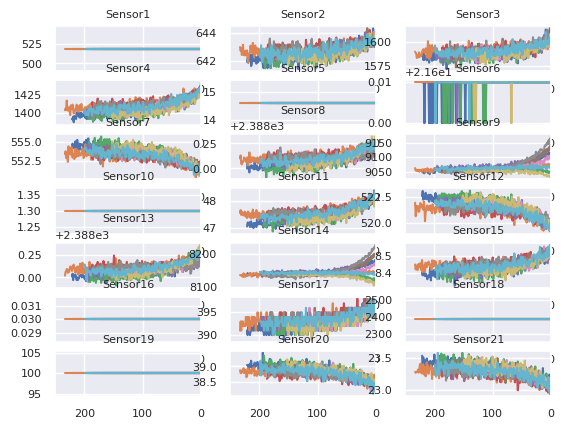

In [45]:
plt.rc('font', size=8) #controls default text size
plt.rc('axes', titlesize=8) #fontsize of the title
plt.rc('axes', labelsize=8) #fontsize of the x and y labels
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels
plt.rc('ytick', labelsize=8) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend
fig, ax = plt.subplots(nrows=7, ncols=3)
#fig.tight_layout(pad=1.0)
i = 1
for row in ax:
    for col in row:
        s = "Sensor"+str(i)
        if i == 22:
            break
        for j in train['UnitNumber'].unique():
            if (j % 10 == 0):
                col.plot(output[0], s, data=train[train['UnitNumber']==j])
        col.set_xlim([250,0])
        col.set_title("Sensor"+str(i), fontsize = 8)
        #plt.tick_params(axis='both', which='major', labelsize=2)
        i = i + 1

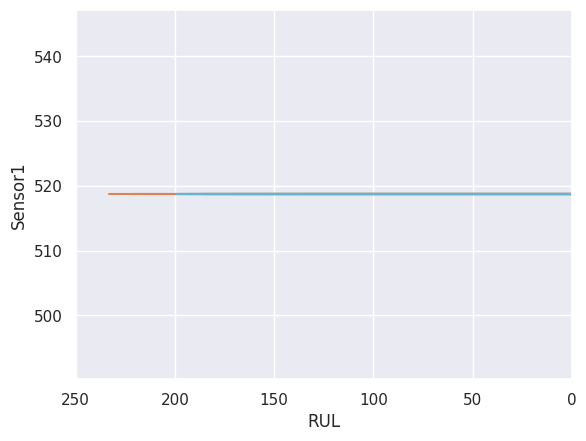

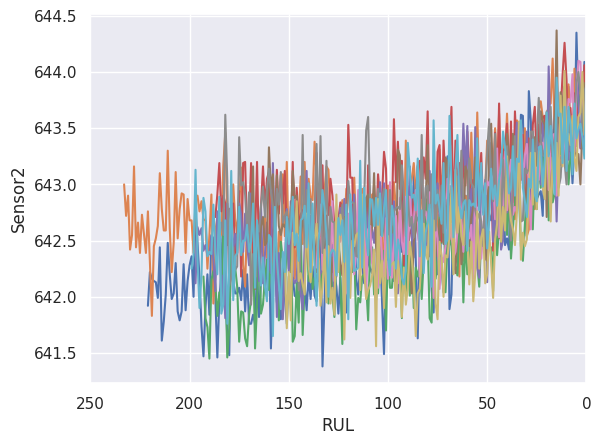

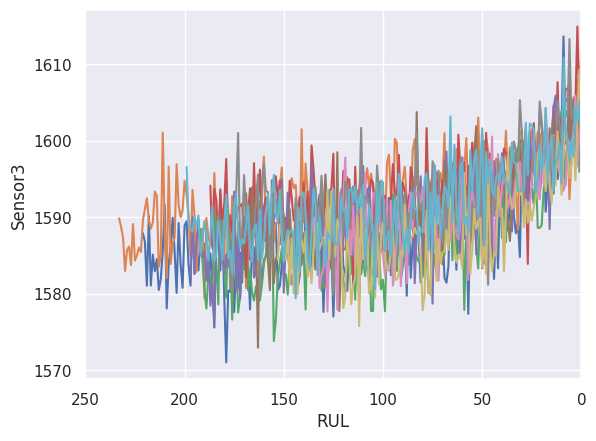

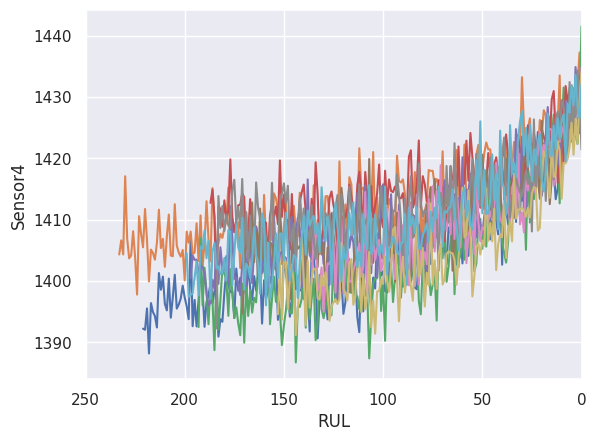

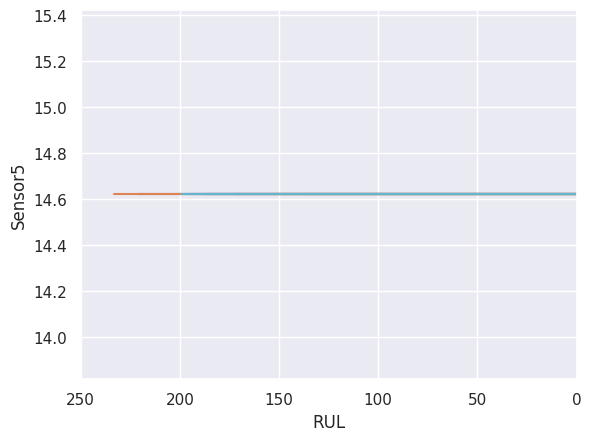

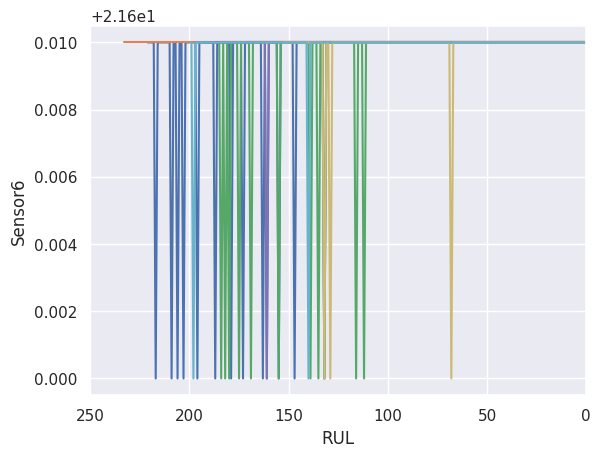

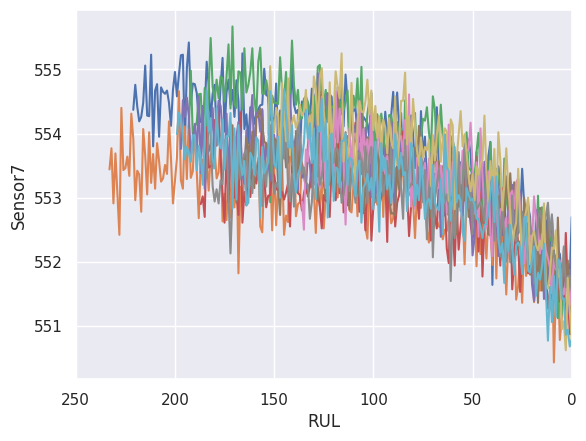

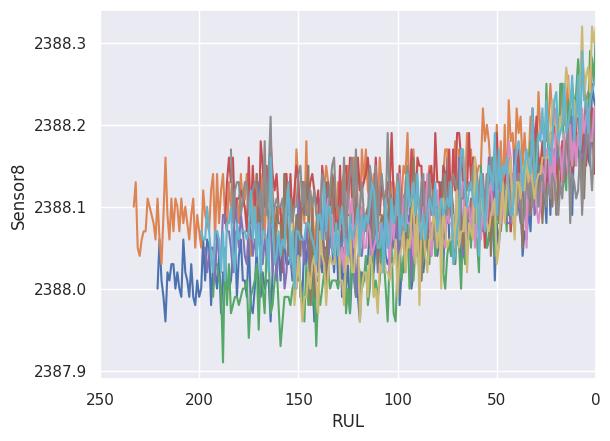

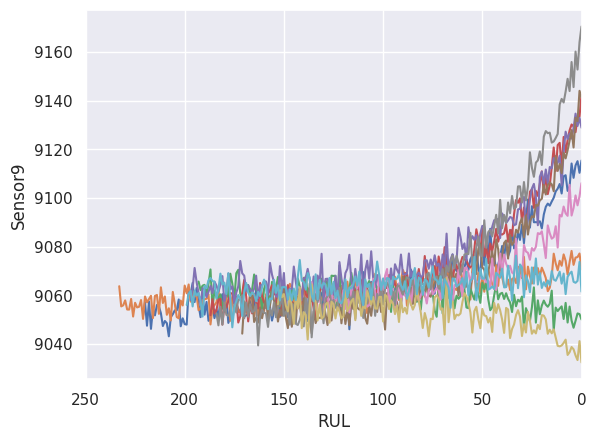

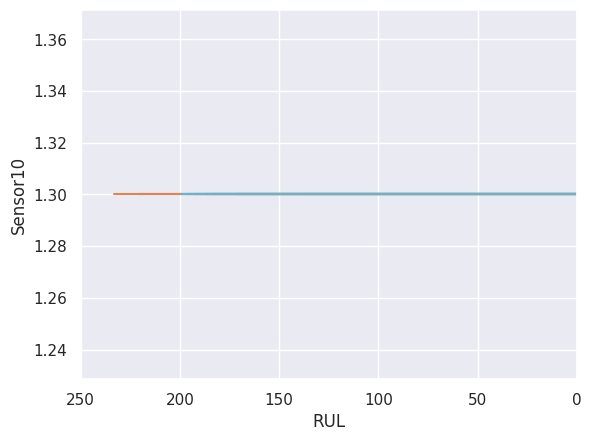

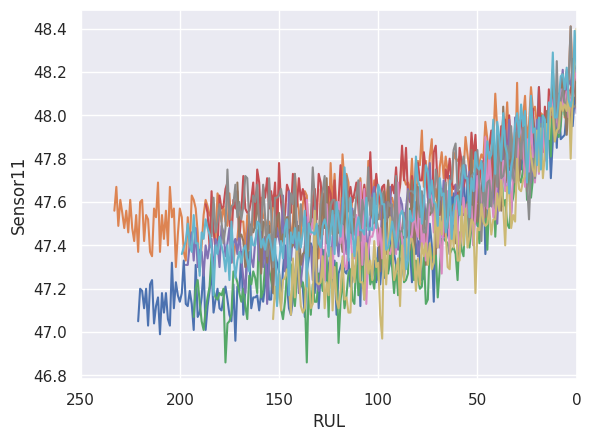

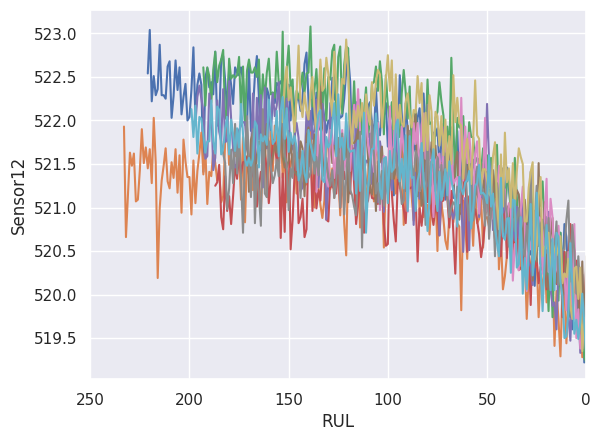

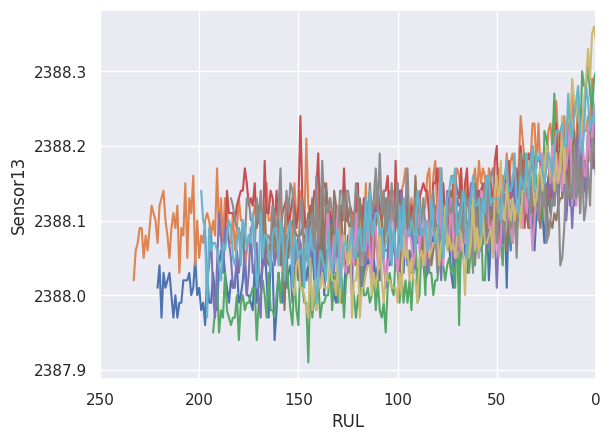

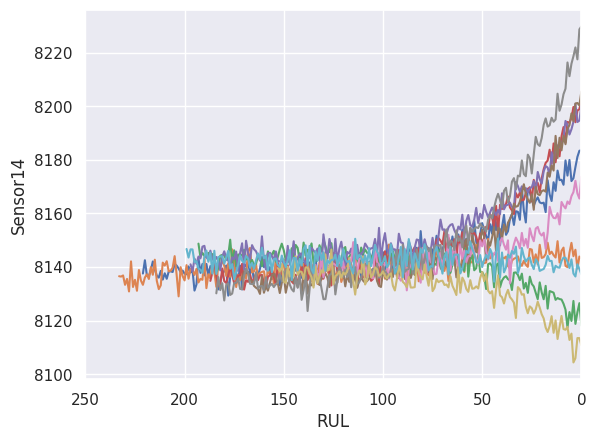

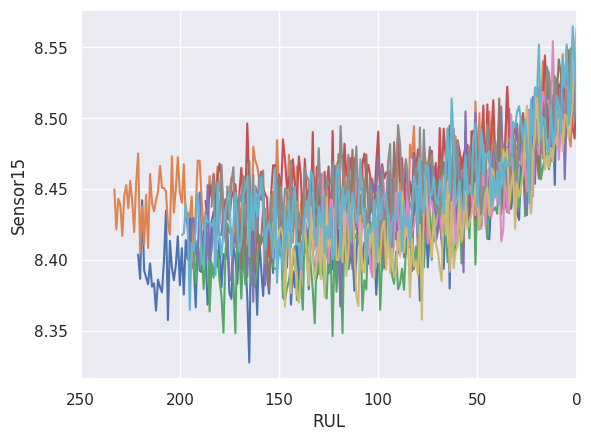

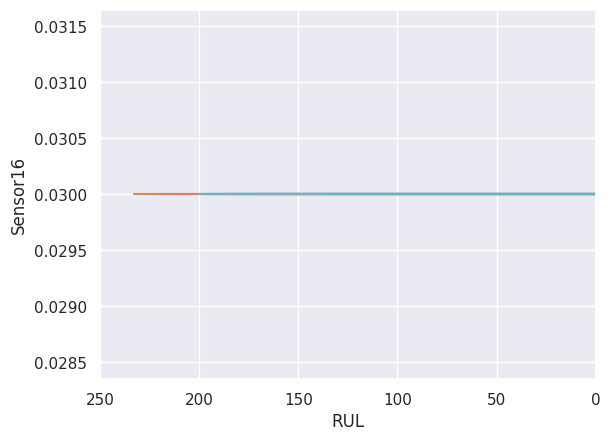

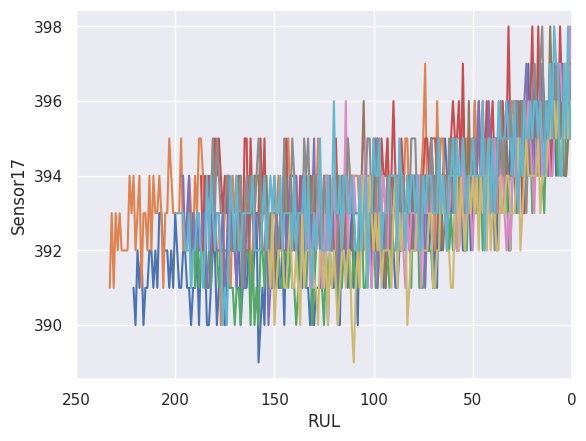

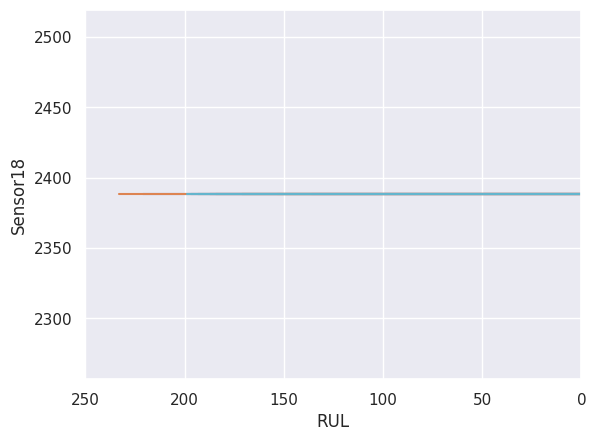

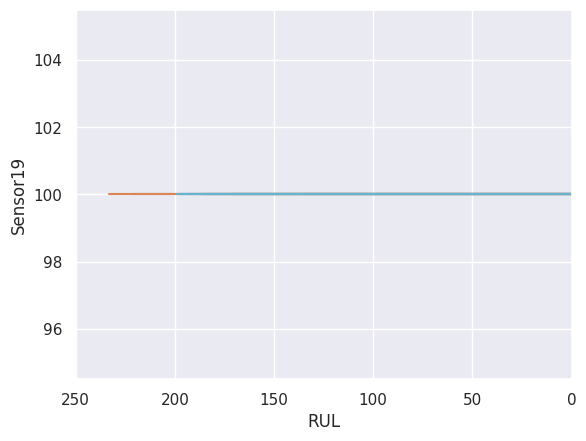

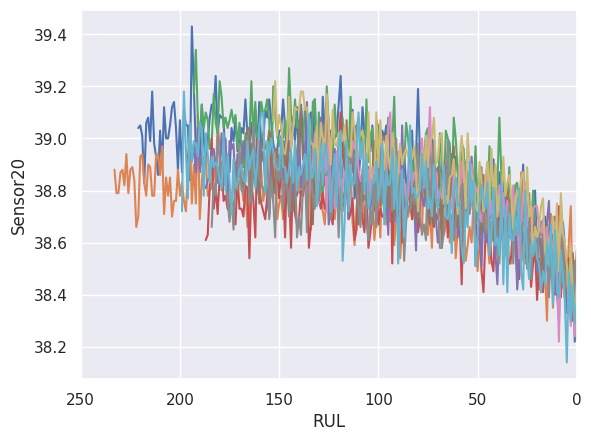

In [54]:
for s in ["Sensor"+str(i) for i in range(1,21)]:
    plt.figure()
    for i in train['UnitNumber'].unique():
        if (i % 10 == 0):
            plt.plot(output[0], s, data=train[train['UnitNumber']==i])
    plt.xlim(250, 0) 
    plt.xlabel('RUL')
    plt.ylabel(s)
    plt.show()
 

### Feature selection

In [46]:
correlation=train.corr()
selectedfeats = correlation[abs(correlation[output[0]])>=0.35]

features_index=selectedfeats.index
features_index=features_index[1:]
train1=train[features_index]

selectedfeats[output[0]]

Cycle      -0.736241
Sensor2    -0.606484
Sensor3    -0.584520
Sensor4    -0.678948
Sensor7     0.657223
Sensor8    -0.563968
Sensor9    -0.390102
Sensor11   -0.696228
Sensor12    0.671983
Sensor13   -0.562569
Sensor15   -0.642667
Sensor17   -0.606154
Sensor20    0.629428
Sensor21    0.635662
RUL         1.000000
Name: RUL, dtype: float64

### creating the test and train sets

In [47]:
y_train = train1[output[0]]
y_train = y_train.clip(upper=125)
x_train = train1.drop([output[0]],axis=1)

test_n = test.groupby('UnitNumber').last().reset_index().drop(["UnitNumber","Cycle"], axis=1)
x_test_n = test_n[x_train.columns]
y_test_n = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=output)
y_test_n = y_test_n.RUL.values

x_test = test[x_train.columns]
y_test = test[output[0]]
y_test = y_test.clip(upper=125)
test.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0           1      1  0.0023  0.0003   100.0   518.67   643.02  1585.29   
1           1      2 -0.0027 -0.0003   100.0   518.67   641.71  1588.45   
2           1      3  0.0003  0.0001   100.0   518.67   642.46  1586.94   
3           1      4  0.0042  0.0000   100.0   518.67   642.44  1584.12   
4           1      5  0.0014  0.0000   100.0   518.67   642.51  1587.19   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0  1398.21    14.62  ...   2388.03   8125.55    8.4052      0.03       392   
1  1395.42    14.62  ...   2388.06   8139.62    8.3803      0.03       393   
2  1401.34    14.62  ...   2388.03   8130.10    8.4441      0.03       393   
3  1406.42    14.62  ...   2388.05   8132.90    8.3917      0.03       391   
4  1401.92    14.62  ...   2388.03   8129.54    8.4031      0.03       390   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0      2388     100.0     38.86   23.3735   30  
1      2388     100.0     39.02   23.3916   29  
2      2388     100.0     39.08   23.4166   28  
3      2388     100.0     39.00   23.3737   27  
4      2388     100.0     38.99   23.4130   26  

[5 rows x 27 columns]

### first model: linear regression

In [48]:
Scaler = StandardScaler()
x_trainN = Scaler.fit_transform(x_train)
x_testN = Scaler.transform(x_test)

Linear_reg = LinearRegression()
Linear_reg.fit(x_trainN, y_train)

y_pred = Linear_reg.predict(x_trainN)
print('Train RMSE:{}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred_test = Linear_reg.predict(x_testN)
print('Test RMSE:{}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Train RMSE:21.51575354385325
Test RMSE:51.73695367460334


Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Train Data')

<Figure size 640x480 with 0 Axes>

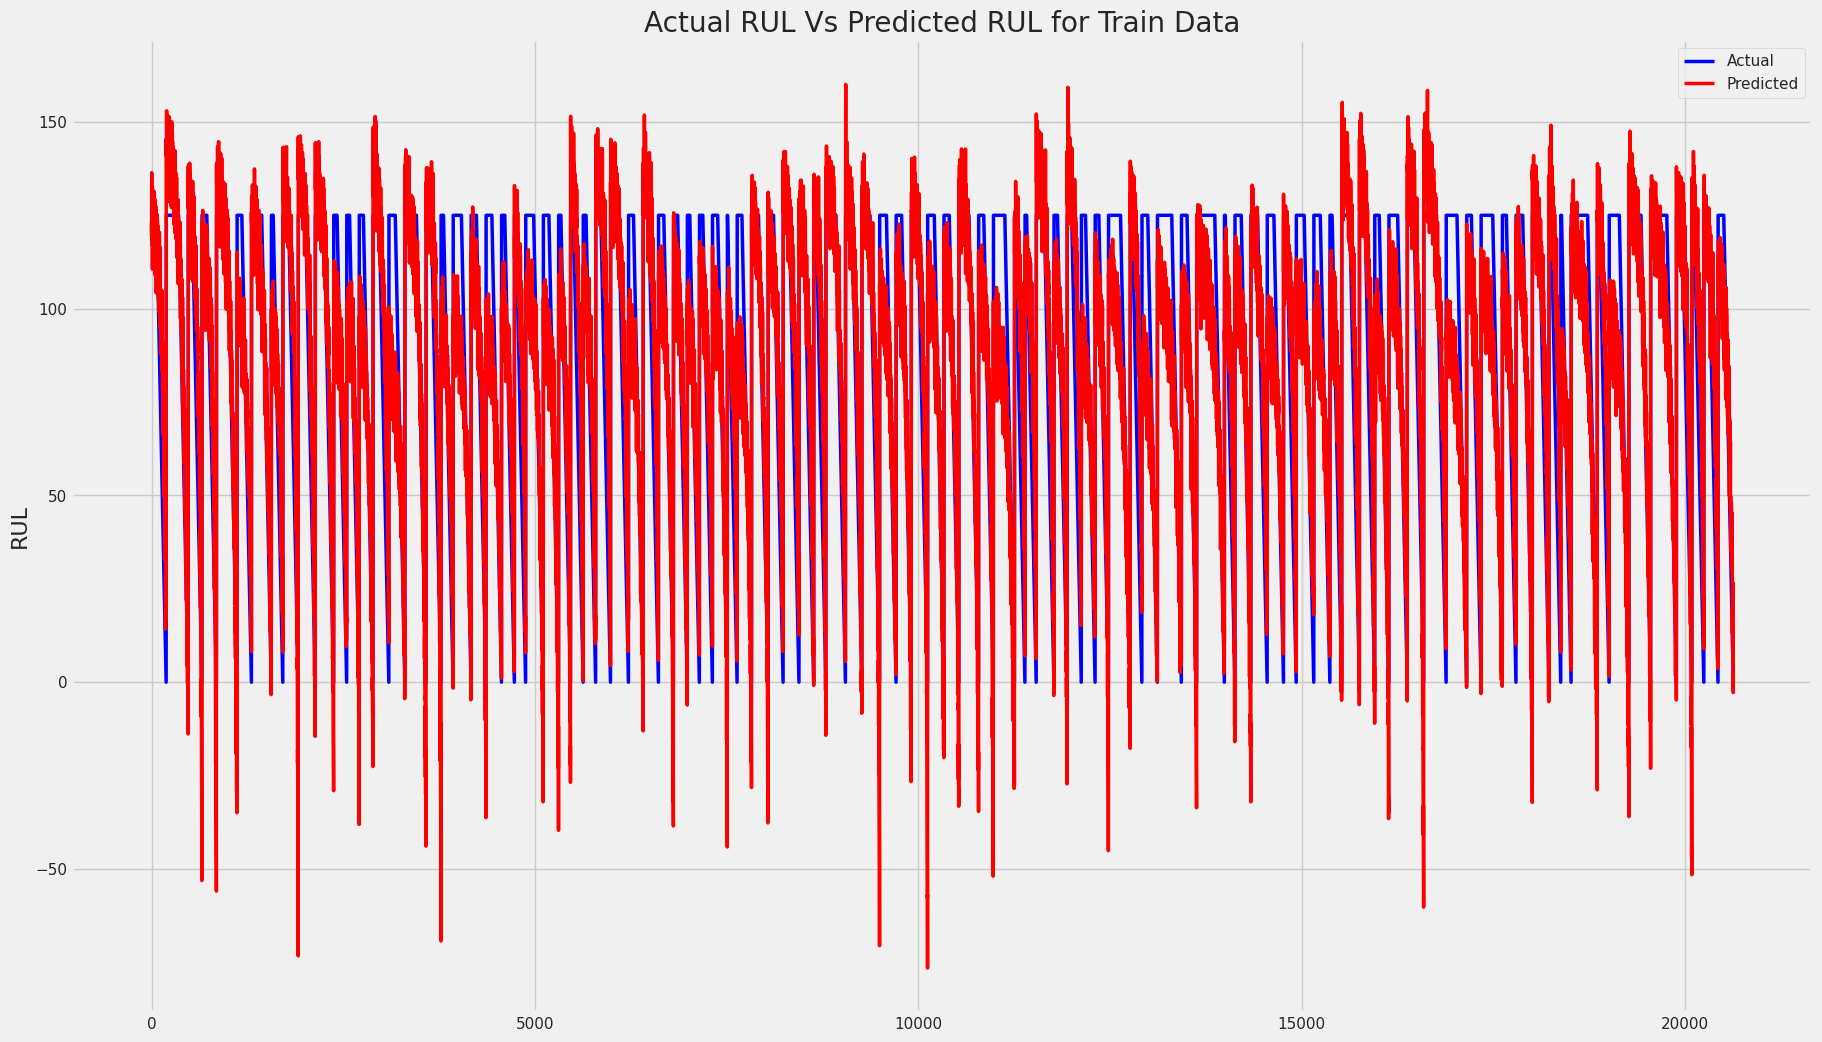

In [98]:
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_train,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_pred,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
plt.ylabel('RUL', fontsize=16)   
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Train Data")

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 640x480 with 0 Axes>

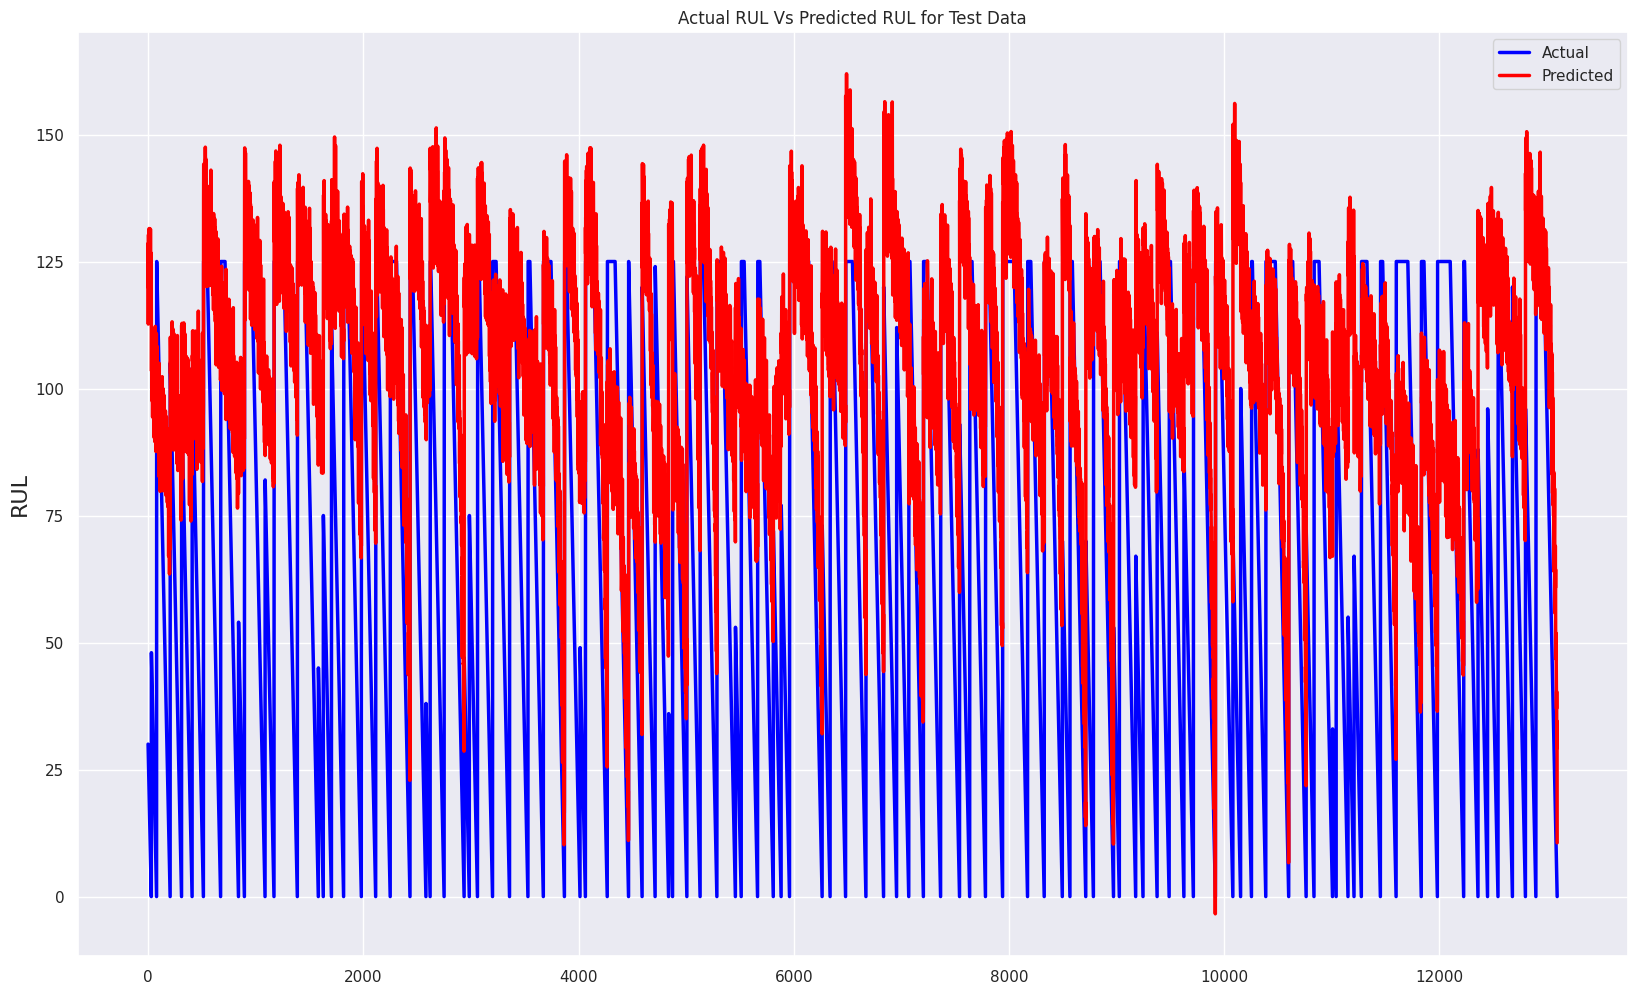

In [60]:
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_pred_test,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
plt.ylabel('RUL', fontsize=16)   
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")

In [13]:
y_pre_n = Linear_reg.predict(Scaler.transform(x_test_n))
print('Test RMSE:{}'.format(np.sqrt(mean_squared_error(y_test_n, y_pre_n))))

Test RMSE:22.070172572124736


Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 640x480 with 0 Axes>

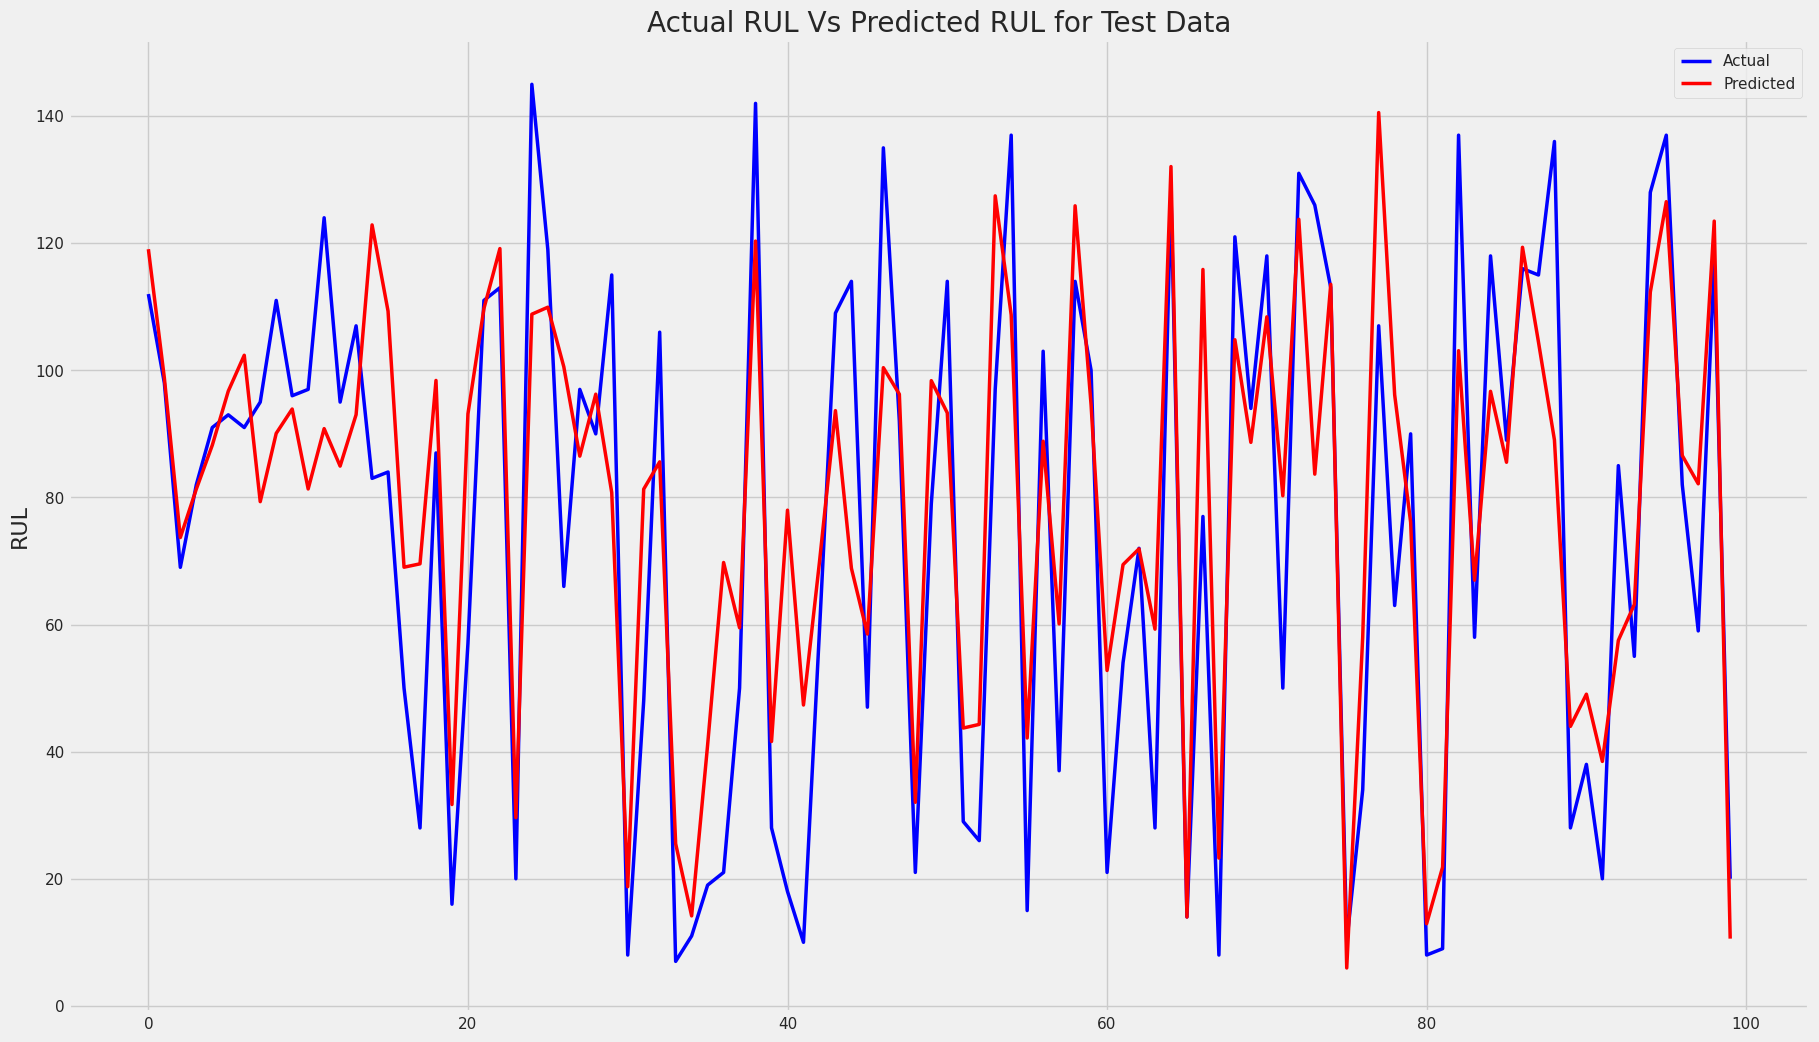

In [96]:
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_test_n,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_pre_n,color="red",  linewidth=2.5, linestyle="-",label="Predicted")            
plt.ylabel('RUL', fontsize=16)   
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")

In [14]:
Result=pd.DataFrame({'Model':['Linear Regression'],'RMSE-Train':[np.sqrt(mean_squared_error(y_train, y_pred))],'MAX_E-Train':[max_error(y_train, y_pred)],'MBE-Train':[np.mean(y_train-y_pred)],'RMSE-Test':[np.sqrt(mean_squared_error(y_test_n, y_pre_n))],'MAX_E-Test':[max_error(y_test_n, y_pre_n)],'MBE-Test':[np.mean(y_test_n-y_pre_n)]})
Result

Model  RMSE-Train  MAX_E-Train     MBE-Train  RMSE-Test  \
0  Linear Regression   21.515754    76.501468  2.865453e-15  22.070173   

   MAX_E-Test  MBE-Test  
0   59.990213 -3.987699

### Second model: Gated Recurrent Unit (GRU)

Pre-processing the dataset

In [50]:
plt.style.use('fivethirtyeight')

In [49]:
train2=pd.concat([train[["UnitNumber","Cycle","OpSet1","OpSet2"]],train[features_index]], axis=1)
df_train, df_test, y_true = train2, test[train2.columns.drop(output[0])], pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=output)
y_true["UnitNumber"] = y_true.index
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [51]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

/var/tmp/ipykernel_1255718/3749437594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[feats] = min_max_scaler.fit_transform(df_test[feats])


In [17]:
df_train.head()

UnitNumber  Cycle    OpSet1    OpSet2   Sensor2   Sensor3   Sensor4  \
0           1      1 -0.080460 -0.666667 -0.632530 -0.186396 -0.380486   
1           1      2  0.218391 -0.500000 -0.433735 -0.093961 -0.294733   
2           1      3 -0.494253  0.500000 -0.313253 -0.260955 -0.258947   
3           1      4  0.080460  0.000000 -0.313253 -0.487683 -0.337610   
4           1      5 -0.218391 -0.333333 -0.301205 -0.485066 -0.190749   

    Sensor7   Sensor8   Sensor9  Sensor11  Sensor12  Sensor13  Sensor15  \
0  0.452496 -0.515152 -0.780490 -0.261905  0.266525 -0.588235 -0.272028   
1  0.256039 -0.575758 -0.799515 -0.238095  0.530917 -0.441176 -0.177376   
2  0.420290 -0.454545 -0.719914 -0.500000  0.590618 -0.558824 -0.285110   
3  0.481481 -0.363636 -0.750965 -0.666667  0.778252 -0.411765 -0.666795   
4  0.336554 -0.515152 -0.700081 -0.488095  0.492537 -0.529412 -0.195845   

   Sensor17  Sensor20  Sensor21  RUL  
0 -0.333333  0.426357  0.449323  191  
1 -0.333333  0.333333  0.462027  190  
2 -0.666667  0.255814  0.242751  189  
3 -0.333333  0.147287  0.324772  188  
4 -0.166667  0.178295  0.409003  187

the training & testing fuctions for train and test sets generation

In [52]:
def func_train(id_samples, seq_len, f):
    ###id_samples = train dataframe (samples)
    ###seq_len = look back period (time steps)
    ###seq_cols = feature columns (features)  
    data = id_samples[f].values
    size = data.shape[0]
    gru_seq=[]
    for start, stop in zip(range(0, size-seq_len+1), range(seq_len, size+1)):
        gru_seq.append(data[start:stop, :])       
    return gru_seq
def func_y(id_samples, seq_len, f):
    data = id_samples[f].values
    size = data.shape[0]
    return data[seq_len-1:size+1]
def func_test(id_samples, seq_length, f, mask_value):
    mask_n = pd.DataFrame(np.zeros((seq_len-1,id_samples.shape[1])),columns=id_samples.columns)
    mask_n[:] = mask
    id_samples = mask_n.append(id_samples,ignore_index=True)
    data = id_samples[f].values
    size = data.shape[0]
    gru_seq=[]
    gru_seq.append(data[size-seq_len:size, :])
    return gru_seq

In [53]:
seq_len = 50
mask = 0

x_train = np.concatenate([func_train(df_train[df_train['UnitNumber']==unit_id], seq_len, feats) for unit_id in df_train['UnitNumber'].unique()])
print(x_train.shape)

y_train = np.concatenate([func_y(df_train[df_train['UnitNumber']==unit_id], seq_len, "RUL") for unit_id in df_train['UnitNumber'].unique()])
print(y_train.shape)

x_test = np.concatenate([func_test(df_test[df_test['UnitNumber']==unit_id], seq_len, feats, mask) for unit_id in df_test['UnitNumber'].unique()])
print(x_test.shape)

y_test = y_true.RUL.values
print(y_test.shape)

y_train = np.clip(y_train, a_min=0, a_max=125)
#y_test = np.clip(y_test, a_min=0, a_max=125)

(15731, 50, 15)
(15731,)
(100, 50, 15)
(100,)


/var/tmp/ipykernel_1255718/3082127808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_samples = mask_n.append(id_samples,ignore_index=True)


### GRU Deep network

In [68]:
history = History()

model = Sequential()
model.add(GRU(100,return_sequences=True,input_shape=(seq_len, x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(10,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 50, 100)           35100     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
gru_27 (GRU)                 (None, 10)                3360      
_________________________________________________________________
dropout_23 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 38,471
Trainable params: 38,471
Non-trainable params: 0
_________________________________________________

In [69]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/100
443/443 [==============================] - 36s 76ms/step - loss: 6318.5479 - mse: 6318.5479 - val_loss: 6776.3931 - val_mse: 6776.3931
Epoch 2/100
443/443 [==============================] - 32s 72ms/step - loss: 5684.5410 - mse: 5684.5410 - val_loss: 6117.6470 - val_mse: 6117.6470
Epoch 3/100
443/443 [==============================] - 32s 72ms/step - loss: 5099.0332 - mse: 5099.0332 - val_loss: 5507.7969 - val_mse: 5507.7969
Epoch 4/100
443/443 [==============================] - 32s 72ms/step - loss: 4570.8706 - mse: 4570.8706 - val_loss: 4944.2246 - val_mse: 4944.2246
Epoch 5/100
443/443 [==============================] - 31s 71ms/step - loss: 4083.9790 - mse: 4083.9790 - val_loss: 4426.5762 - val_mse: 4426.5762
Epoch 6/100
443/443 [==============================] - 32s 72ms/step - loss: 3657.8857 - mse: 3657.8857 - val_loss: 3958.8340 - val_mse: 3958.8340
Epoch 7/100
443/443 [==============================] - 31s 70ms/step - loss: 3273.2031 - mse: 3273.2031 - val_loss: 35

### Ploting the actual and predicted RUL for the test set

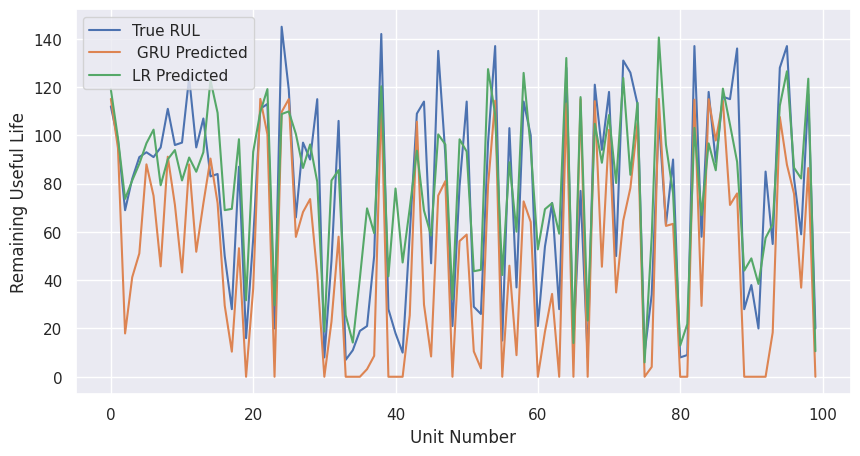

In [97]:
y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred_test, label=' GRU Predicted')
plt.plot(y_pre_n,label="LR Predicted")            
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [98]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('Train RMSE: {}'.format(np.sqrt(scores[1])))
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))

79/79 [==============================] - 3s 40ms/step - loss: 132.1941 - mse: 132.1941
Train RMSE: 11.497570942300907
4/4 - 0s - loss: 1018.9391 - mse: 1018.9391
Test RMSE: 31.92082624164385


second test set generation

In [99]:
y_pred_train = model.predict(x_train, verbose=0)
Result = Result.append(pd.DataFrame({'Model':['GRU'],'RMSE-Train':[np.sqrt(scores[1])],'MAX_E-Train':[max_error(y_pred_train, y_train)],'MBE-Train':[np.mean(y_train-y_pred_train)],'RMSE-Test':[np.sqrt(scores_test[1])],'MAX_E-Test':[max_error(y_test, y_pred_test)],'MBE-Test':[np.mean(y_test-y_pred_test)]}),ignore_index=True)

/var/tmp/ipykernel_9524/2344551015.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result = Result.append(pd.DataFrame({'Model':['GRU'],'RMSE-Train':[np.sqrt(scores[1])],'MAX_E-Train':[max_error(y_pred_train, y_train)],'MBE-Train':[np.mean(y_train-y_pred_train)],'RMSE-Test':[np.sqrt(scores_test[1])],'MAX_E-Test':[max_error(y_test, y_pred_test)],'MBE-Test':[np.mean(y_test-y_pred_test)]}),ignore_index=True)


In [54]:
def func_test2(id_samples, seq_len, f, mask_value):
    mask_n = pd.DataFrame(np.zeros((seq_len-1,id_samples.shape[1])),columns=id_samples.columns)
    mask_n[:] = mask
    id_samples = mask_n.append(id_samples,ignore_index=True)
    
    data = id_samples[f].values
    size = data.shape[0]
    gru_seq=[]
    for start, stop in zip(range(0, size-seq_len+1), range(seq_len, size+1)):
        gru_seq.append(data[start:stop, :])       
    return gru_seq
def func_y2(id_samples, seq_len, f):
    data = id_samples[f].values
    size = data.shape[0]
    return data[:size+1]

In [55]:
df_test2 = test[train2.columns]
df_test2[feats] = min_max_scaler.fit_transform(df_test2[feats])

y_test2 = np.concatenate([func_y2(df_test2[df_test2['UnitNumber']==unit_id], seq_len, "RUL") for unit_id in df_test2['UnitNumber'].unique()])
print(y_test2.shape)
x_test2 = np.concatenate([func_test2(df_test2[df_test2['UnitNumber']==unit_id], seq_len, feats, mask) for unit_id in df_test2['UnitNumber'].unique()])
print(x_test2.shape)

/var/tmp/ipykernel_1255718/2664525710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2[feats] = min_max_scaler.fit_transform(df_test2[feats])
/var/tmp/ipykernel_1255718/1394786202.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_samples = mask_n.append(id_samples,ignore_index=True)


(13096,)
(13096, 50, 15)


In [134]:
y_pred_test2 = model.predict(x_test2, verbose=0)

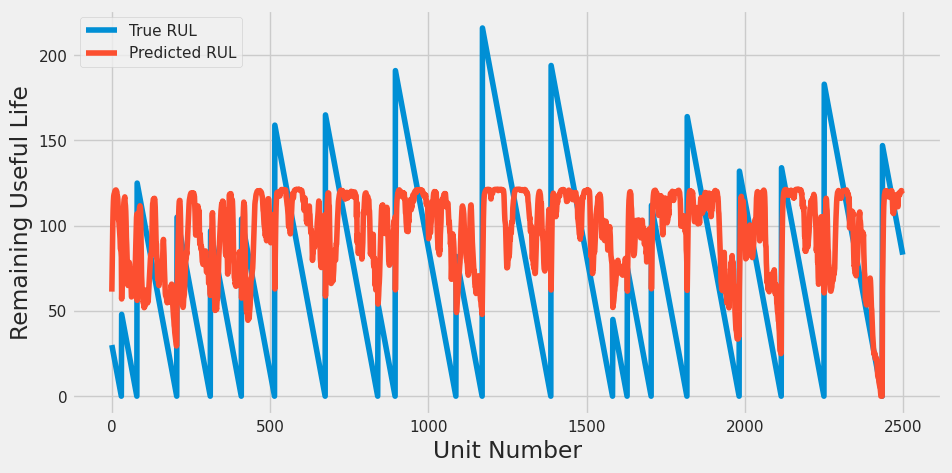

In [135]:
plt.figure(figsize=(10,5))
plt.plot(y_test2[:2500], label='True RUL')
plt.plot(y_pred_test2[:2500], label='Predicted RUL')
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

### Third model: CNN

In [56]:
train_reshaped = np.array(df_train).reshape(df_train.shape[0],df_train.shape[1],1)
train_reshaped_x = train_reshaped[:,2:17,:]
print(train_reshaped_x.shape)
train_reshaped_y = train_reshaped[:,17,:]
train_reshaped_y = np.clip(train_reshaped_y, a_min=0, a_max=125)
print(train_reshaped_y.shape)
test_reshaped = np.array(df_test2).reshape(df_test2.shape[0],df_train.shape[1],1)
test_reshaped_x = test_reshaped[:,2:17,:]
print(test_reshaped_x.shape)
test_reshaped_y = test_reshaped[:,17,:]
print(test_reshaped_y.shape)

(20631, 15, 1)
(20631, 1)
(13096, 15, 1)
(13096, 1)


In [68]:
n_timesteps = train_reshaped_x.shape[1]
n_features  = train_reshaped_x.shape[2]  
numHiddenUnits = 100;

historycnn = History()

model2 = Sequential()
model2.add(keras.layers.Input(shape=(n_timesteps,n_features)))
model2.add(keras.layers.Conv1D(5,32,padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.Conv1D(7,64,padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.Conv1D(11,128,padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.Conv1D(13,256,padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.Conv1D(15,512,padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.MaxPooling1D(pool_size=2))
model2.add(keras.layers.Flatten())
model2.add(Dense(numHiddenUnits, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='relu'))

model2.compile(loss="mse", optimizer="adam", metrics=['mse'])

model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15, 5)             165       
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 5)             20        
_________________________________________________________________
re_lu_15 (ReLU)              (None, 15, 5)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 15, 7)             2247      
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 7)             28        
_________________________________________________________________
re_lu_16 (ReLU)              (None, 15, 7)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 15, 11)           

In [59]:
model2.fit(train_reshaped_x, train_reshaped_y, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
          callbacks = [historycnn, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')])

2023-08-17 09:03:55.448939: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
516/516 [==============================] - 18s 32ms/step - loss: 1041.5527 - mse: 1041.5527 - val_loss: 438.3536 - val_mse: 438.3536
Epoch 2/100
516/516 [==============================] - 14s 28ms/step - loss: 527.4225 - mse: 527.4225 - val_loss: 370.4418 - val_mse: 370.4418
Epoch 3/100
516/516 [==============================] - 14s 28ms/step - loss: 500.6210 - mse: 500.6210 - val_loss: 370.4761 - val_mse: 370.4761
Epoch 4/100
516/516 [==============================] - 15s 28ms/step - loss: 506.9918 - mse: 506.9918 - val_loss: 497.7982 - val_mse: 497.7982


In [60]:
scores = model2.evaluate(train_reshaped_x, train_reshaped_y, verbose=1, batch_size=200)
print('Train RMSE: {}'.format(np.sqrt(scores[1])))
scores_test = model2.evaluate(test_reshaped_x, test_reshaped_y, verbose=2)
print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))

104/104 [==============================] - 4s 37ms/step - loss: 490.3812 - mse: 490.3812
Train RMSE: 22.144551577098625
410/410 - 3s - loss: 2438.0667 - mse: 2438.0667
Test RMSE: 49.376782503425886


In [82]:
y_pred_test3 = model2.predict(test_reshaped_x, verbose=0)

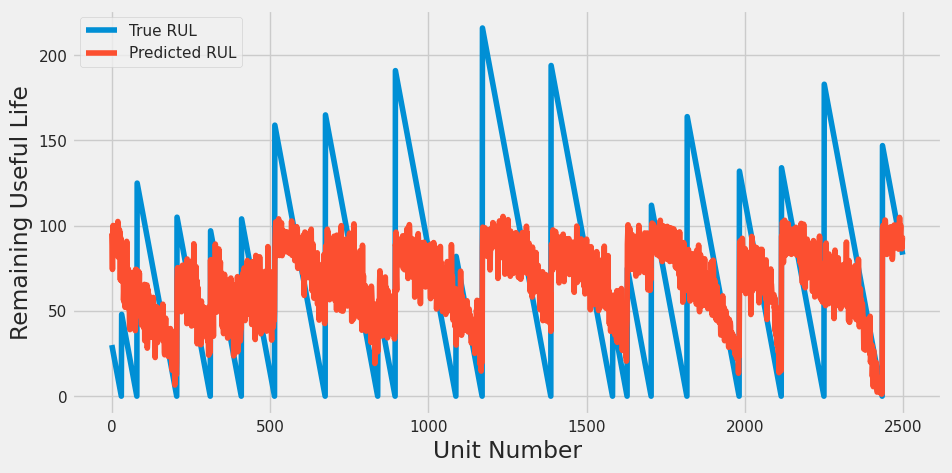

In [183]:
plt.figure(figsize=(10,5))
plt.plot(test_reshaped_y[:2500], label='True RUL')
plt.plot(y_pred_test3[:2500], label='Predicted RUL')
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [61]:
x_test_n = df_test2.groupby('UnitNumber').last().reset_index()
x_test_n = np.array(x_test_n).reshape(x_test_n.shape[0],x_test_n.shape[1],1)
x_test_n = x_test_n[:,2:17,:]
print(x_test_n.shape)

(100, 15, 1)


### Ploting the actual and predicted RUL for the test set

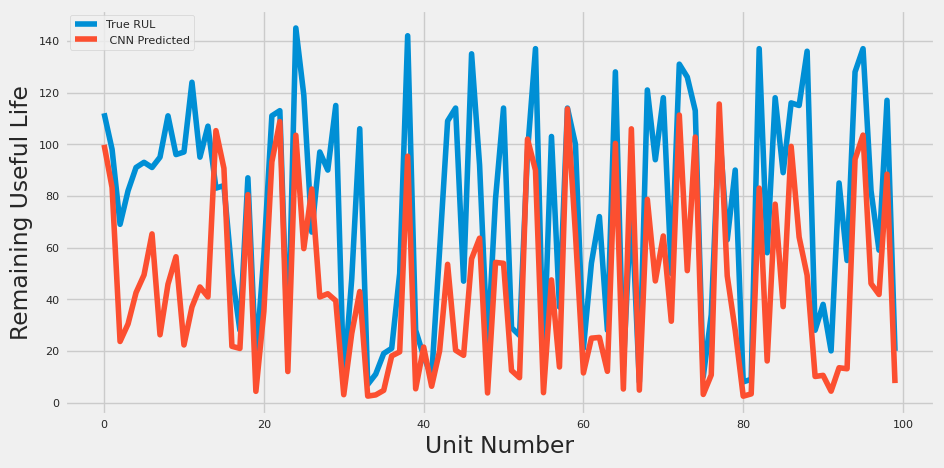

In [63]:
y_pred_test4 = model2.predict(x_test_n, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred_test4, label=' CNN Predicted')
#plt.plot(y_pred_test, label=' GRU Predicted')
#plt.plot(y_pre_n,label="LR Predicted")            
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [85]:
y_pred_train = model2.predict(train_reshaped_x, verbose=0)
Result = Result.append(pd.DataFrame({'Model':['CNN'],'RMSE-Train':[np.sqrt(scores[1])],'MAX_E-Train':[max_error(y_pred_train, train_reshaped_y)],'MBE-Train':[np.mean(train_reshaped_y-y_pred_train)],'RMSE-Test':[np.sqrt(mean_squared_error(y_test, y_pred_test4))],'MAX_E-Test':[max_error(y_test, y_pred_test4)],'MBE-Test':[np.mean(y_test-y_pred_test4)]}),ignore_index=True)

/var/tmp/ipykernel_9524/3214349223.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result = Result.append(pd.DataFrame({'Model':['CNN'],'RMSE-Train':[np.sqrt(scores[1])],'MAX_E-Train':[max_error(y_pred_train, train_reshaped_y)],'MBE-Train':[np.mean(train_reshaped_y-y_pred_train)],'RMSE-Test':[np.sqrt(mean_squared_error(y_test, y_pred_test4))],'MAX_E-Test':[max_error(y_test, y_pred_test4)],'MBE-Test':[np.mean(y_test-y_pred_test4)]}),ignore_index=True)


### 4th model: XG Booster Regression model

In [100]:
y_train = train1[output[0]]
y_train = y_train.clip(upper=125)
x_train = train1.drop([output[0]],axis=1)

test_n = test.groupby('UnitNumber').last().reset_index().drop(["UnitNumber","Cycle"], axis=1)
x_test_n = test_n[x_train.columns]
y_test_n = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=output)
y_test_n = y_test_n.RUL.values

In [101]:
xgboost = xg.XGBRegressor(objective ='reg:linear',n_estimators = 25, seed = 12)
xgboost.fit(x_trainN, y_train)

[15:28:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [102]:
y_pre_tr = xgboost.predict(x_trainN)
print('Train RMSE:{}'.format(np.sqrt(mean_squared_error(y_train, y_pre_tr))))

Train RMSE:16.07501342329041


In [103]:
y_pre = xgboost.predict(Scaler.transform(x_test_n))
print('Test RMSE:{}'.format(np.sqrt(mean_squared_error(y_test_n, y_pre))))

Test RMSE:18.090742153113197


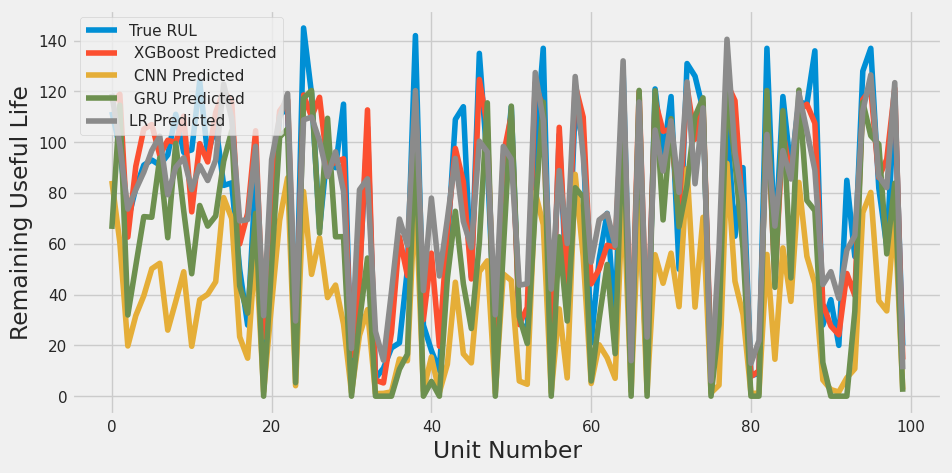

In [266]:
plt.figure(figsize=(10,5))
plt.plot(y_test_n, label='True RUL')
plt.plot(y_pre, label=' XGBoost Predicted')
plt.plot(y_pred_test4, label=' CNN Predicted')
plt.plot(y_pred_test, label=' GRU Predicted')
plt.plot(y_pre_n,label="LR Predicted")            
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

### RMSE Comparison

In [90]:
Result = Result.append(pd.DataFrame({'Model':['XGBooster'],'RMSE-Train':[np.sqrt(mean_squared_error(y_train, y_pre_tr))],'MAX_E-Train':[max_error(y_pre_tr, y_train)],'MBE-Train':[np.mean(y_train-y_pre_tr)],'RMSE-Test':[np.sqrt(mean_squared_error(y_test_n, y_pre))],'MAX_E-Test':[max_error(y_test_n, y_pre)],'MBE-Test':[np.mean(y_test_n-y_pre)]}),ignore_index=True)

/var/tmp/ipykernel_9524/2945512686.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result = Result.append(pd.DataFrame({'Model':['XGBooster'],'RMSE-Train':[np.sqrt(mean_squared_error(y_train, y_pre_tr))],'MAX_E-Train':[max_error(y_pre_tr, y_train)],'MBE-Train':[np.mean(y_train-y_pre_tr)],'RMSE-Test':[np.sqrt(mean_squared_error(y_test_n, y_pre))],'MAX_E-Test':[max_error(y_test_n, y_pre)],'MBE-Test':[np.mean(y_test_n-y_pre)]}),ignore_index=True)


Model  RMSE-Train  MAX_E-Train     MBE-Train  RMSE-Test  \
0  Linear Regression   21.515754    76.501468  2.865453e-15  22.070173   
1                CNN   18.324684    81.377495 -2.876614e+00  44.463660   
2          XGBooster   16.075013    77.250069  8.118975e-03  18.090742   

   MAX_E-Test   MBE-Test  
0   59.990213  -3.987699  
1   96.416950  36.217277  
2   53.374916  -2.499637

### 5th model: Multilayer Perceptron (MLP)

In [104]:
historymlp = History()
model3 = Sequential()
model3.add(Dense(25, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [105]:
#model3.fit(x_trainN, y_train, batch_size = 64, epochs = 25)
model3.fit(x_trainN, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1,
          callbacks = [historymlp, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')])

Epoch 1/100
1032/1032 [==============================] - 2s 2ms/step - loss: 2785.9634 - mae: 39.7521 - val_loss: 429.3711 - val_mae: 16.4838
Epoch 2/100
1032/1032 [==============================] - 2s 1ms/step - loss: 364.1027 - mae: 14.6027 - val_loss: 394.5222 - val_mae: 15.5738
Epoch 3/100
1032/1032 [==============================] - 1s 1ms/step - loss: 352.0558 - mae: 14.2729 - val_loss: 399.6977 - val_mae: 15.9444
Epoch 4/100
1032/1032 [==============================] - 1s 1ms/step - loss: 347.9286 - mae: 14.1112 - val_loss: 380.0746 - val_mae: 15.0680
Epoch 5/100
1032/1032 [==============================] - 1s 1ms/step - loss: 342.7344 - mae: 13.9600 - val_loss: 378.3813 - val_mae: 15.0216
Epoch 6/100
1032/1032 [==============================] - 1s 1ms/step - loss: 337.3643 - mae: 13.7489 - val_loss: 368.0664 - val_mae: 14.6171
Epoch 7/100
1032/1032 [==============================] - 2s 2ms/step - loss: 329.9086 - mae: 13.5401 - val_loss: 363.6958 - val_mae: 14.0810
Epoch 8/100


In [106]:
y_pre_tr1 = model3.predict(x_trainN)
print('Train RMSE:{}'.format(np.sqrt(mean_squared_error(y_train, y_pre_tr1))))
y_pre_test1 = model3.predict(Scaler.transform(x_test_n))
print('Test RMSE:{}'.format(np.sqrt(mean_squared_error(y_test_n, y_pre_test1))))

Train RMSE:17.950535592323003
Test RMSE:17.701191786977375


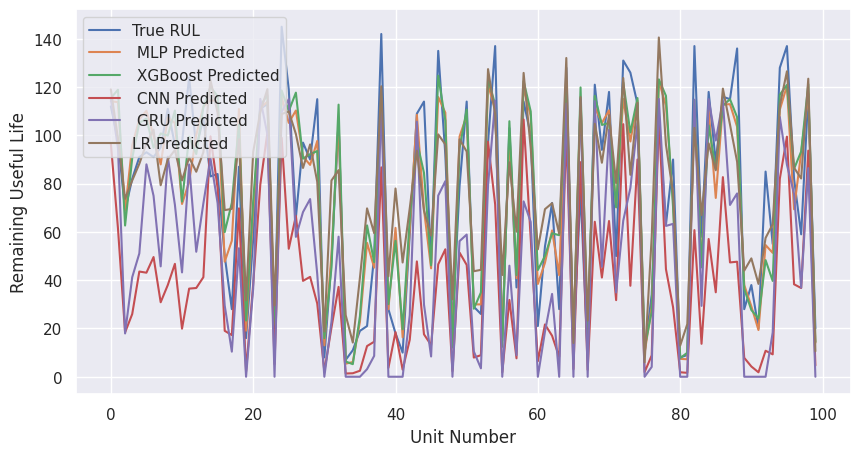

In [113]:
plt.figure(figsize=(10,5))
plt.plot(y_test_n, label='True RUL')
plt.plot(y_pre_test1, label=' MLP Predicted')
plt.plot(y_pre, label=' XGBoost Predicted')
plt.plot(y_pred_test4, label=' CNN Predicted')
plt.plot(y_pred_test, label=' GRU Predicted')
plt.plot(y_pre_n,label="LR Predicted")            
plt.ylabel("Remaining Useful Life")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [114]:
Result = Result.append(pd.DataFrame({'Model':['MLP'],'RMSE-Train':[np.sqrt(mean_squared_error(y_train, y_pre_tr1))],'MAX_E-Train':[max_error(y_pre_tr1, y_train)],'MBE-Train':[np.mean(y_train-y_pre_tr1[:,0])],'RMSE-Test':[np.sqrt(mean_squared_error(y_test_n, y_pre_test1))],'MAX_E-Test':[max_error(y_test_n, y_pre_test1)],'MBE-Test':[np.mean(y_test_n-y_pre_test1)]}),ignore_index=True)
Result

/var/tmp/ipykernel_9524/1882238525.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result = Result.append(pd.DataFrame({'Model':['MLP'],'RMSE-Train':[np.sqrt(mean_squared_error(y_train, y_pre_tr1))],'MAX_E-Train':[max_error(y_pre_tr1, y_train)],'MBE-Train':[np.mean(y_train-y_pre_tr1[:,0])],'RMSE-Test':[np.sqrt(mean_squared_error(y_test_n, y_pre_test1))],'MAX_E-Test':[max_error(y_test_n, y_pre_test1)],'MBE-Test':[np.mean(y_test_n-y_pre_test1)]}),ignore_index=True)


Model  RMSE-Train  MAX_E-Train     MBE-Train  RMSE-Test  \
0  Linear Regression   21.515754    76.501468  2.865453e-15  22.070173   
1                CNN   18.324684    81.377495 -2.876614e+00  44.463660   
2          XGBooster   16.075013    77.250069  8.118975e-03  18.090742   
3                GRU   11.497571    52.132225  2.259348e+00  31.920826   
4                MLP   17.950536    77.330437  1.811578e+00  17.701192   

   MAX_E-Test   MBE-Test  
0   59.990213  -3.987699  
1   96.416950  36.217277  
2   53.374916  -2.499637  
3   85.000000  24.813537  
4   49.292061  -0.715950